# Predeict heatwaves

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_curve, auc, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier 
import statsmodels.api as sm 
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
#import data
url="https://github.com/Themaoyc/MDA/blob/main/Data/temperaturedata_predict.csv?raw=true"
df = pd.read_csv(url)
df.head()

,Country,ISO,Year,January,February,March,April,May,Heatwave
0,Albania,ALB,2004,6.70,8.50,11.7,15.80,17.60,1
1,Albania,ALB,2005,6.60,6.40,10.9,14.10,20.40,0
2,Albania,ALB,2006,5.50,7.80,10.8,15.30,18.80,0
3,Albania,ALB,2007,7.06,8.32,10.9,14.52,18.76,1
4,Albania,ALB,2008,5.40,7.02,10.0,13.40,17.94,0


## Exploring the relationship between temperature and heatwaves

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   1279 non-null   object 
 1   ISO       1279 non-null   object 
 2   Year      1279 non-null   int64  
 3   January   1279 non-null   float64
 4   February  1279 non-null   float64
 5   March     1279 non-null   float64
 6   April     1279 non-null   float64
 7   May       1279 non-null   float64
 8   Heatwave  1279 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 90.1+ KB


In [5]:
df.describe()

,Year,January,February,March,April,May,Heatwave
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,2006.000782,3.337858,4.547357,7.816639,11.904338,16.129467,0.098514
std,9.167414,9.580013,9.410889,8.696419,7.726299,6.822498,0.298126
min,1990.000000,-28.240000,-30.580000,-26.712500,-22.550000,-10.814286,0.000000
25%,1998.000000,-1.650000,-0.400000,3.712500,7.945000,12.312500,0.000000
50%,2006.000000,3.316667,4.350000,7.066667,11.220000,15.700000,0.000000
75%,2014.000000,9.180000,10.558333,13.487500,15.960417,19.650000,0.000000
max,2021.000000,29.000000,31.000000,32.900000,34.100000,36.100000,1.000000


Draw the line chart of temperature for group Heatwave=1 and group Heatwave=0.

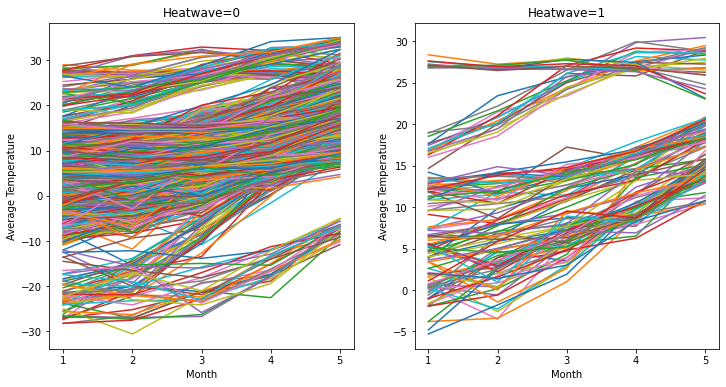

In [7]:
group0=df[df.Heatwave == 0]
group1=df[df.Heatwave == 1]
month=[1,2,3,4,5]
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Heatwave=0')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
for i in range(len(group0)):
 plt.xticks(month)
 plt.plot(month,group0.iloc[i,3:8])
plt.subplot(1,2,2)
plt.title('Heatwave=1')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
for i in range(len(group1)):
 plt.xticks(month)
 plt.plot(month,group0.iloc[i,3:8])

It shows clearly that the 2 groups's temperature tendency differs a lot.<br> 

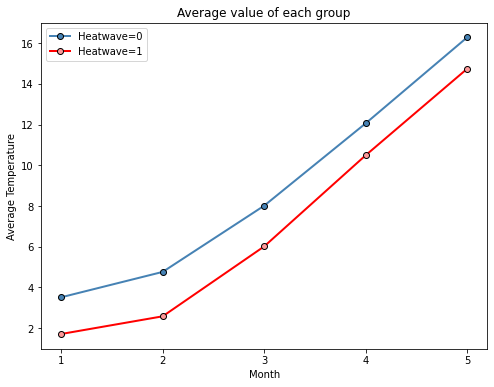

In [8]:
t0=group0.iloc[:,3:8].mean()
t1=group1.iloc[:,3:8].mean()
fig = plt.figure(figsize=(8,6))
plt.title('Average value of each group')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.xticks(month)
plt.plot(month,t0,
         label = 'Heatwave=0',
         linestyle = '-',
         linewidth = 2,
         color = 'steelblue', 
         marker = 'o', 
         markersize = 6, 
         markeredgecolor='black', 
         markerfacecolor='steelblue') 
plt.plot(month, t1, 
         label = 'Heatwave=1',
         linestyle = '-',
         linewidth = 2, 
         color = 'r', 
         marker = 'o', 
         markersize = 6, 
         markeredgecolor='black', 
         markerfacecolor='#ff9999') 
plt.legend()
plt.show()


We first assume that year and country are 2 random efforts and build a mix model to study the differnt temperature tendency in these 2 groups：<br>
<br>
<big>$$Y_{ijk}=\begin{cases}\beta_0+a_{i}+b_{j(i)}+\beta_1t_{k}+\varepsilon_{ijk}, & if \ no \ heatwave\\ \beta_2+a_{i}+b_{j(i)}+\beta_3t_{k}+\varepsilon_{ijk}, & if \ heatwave
\end{cases} $$</big>

where

$Y_{ijk}$ is Monthly Average Temperature for Country i in year j month k

$t_{k}$ is the Month, k=1,2,3,4,5

$a_{i}$ is a Country effect on Monthly Average Temperature which we assume $a_{i} \sim N(0,\tau^2)$

$b_{j(i)}$ is a Year effect on Monthly Average Temperature which we assume $b_{j(i)} \sim N(0,\tau^2)$

$\epsilon_{ij}$ is the deviation for observation k in Country i and Year j which we assume $\epsilon_{ijk} \sim N(0,\sigma^2)$


In [105]:
dflong=pd.melt(df, id_vars=['Country','Year','Heatwave'],value_vars=df.columns[3:8], 
            var_name='Month',value_name='tavg', col_level=None)
dflong.loc[dflong['Month']=='January','Month']=1
dflong.loc[dflong['Month']=='February','Month']=2
dflong.loc[dflong['Month']=='March','Month']=3
dflong.loc[dflong['Month']=='April','Month']=4
dflong.loc[dflong['Month']=='May','Month']=5
dflong['Month']=dflong['Month'].astype(int)
dflong["group"] = 1                                                                                                                                                                                                                                      
vcf = {"Country": "0 + C(Country)", "Year": "0 + C(Year)"}                                                         
model = sm.MixedLM.from_formula("tavg ~ Month+Heatwave+Heatwave*Month", groups="group",                                                    
                                vc_formula=vcf, re_formula="0", data=dflong)                                                   
result = model.fit()  
print(result.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: tavg       
No. Observations:  6395    Method:             REML       
No. Groups:        1       Scale:              8.9529     
Min. group size:   6395    Log-Likelihood:     -16269.1240
Max. group size:   6395    Converged:          Yes        
Mean group size:   6395.0                                 
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      -0.473    1.322  -0.358 0.721 -3.063  2.118
Month           3.283    0.028 117.810 0.000  3.228  3.337
Heatwave       -0.339    0.301  -1.127 0.260 -0.929  0.251
Heatwave:Month  0.114    0.089   1.279 0.201 -0.060  0.288
Country Var    74.337    5.447                            
Year Var        0.300    0.029                            



From the summary we can find that heatwave is not significant. Note that the variable Contry does account for large variance, we then decide to incluede it into our new model.Features and target are defined as follows.

In [9]:
x = df[['Country','Year','January','February','March','April','May']]
y = df[['Heatwave']]
x_type = np.array(x.dtypes)
print(x_type)

[dtype('O') dtype('int64') dtype('float64') dtype('float64')
 dtype('float64') dtype('float64') dtype('float64')]


## Split test and train dataset

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=777,test_size=0.3, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(895, 7)
(895, 1)
(384, 7)
(384, 1)


## Create Transformer

In [11]:
int_ix = x_type==np.dtype('int64')
int_cols = np.where(int_ix)
float_ix = x_type==np.dtype('float64')
float_cols = np.where(float_ix)
categorical_ix = x_type==np.dtype('O')
categorical_cols = np.where(categorical_ix)
print('categorical cols:',categorical_cols[0])
print('int cols:',int_cols[0])
print('float cols:',float_cols[0])

categorical cols: [0]
int cols: [1]
float cols: [2 3 4 5 6]


In [12]:
t = [('cat', OneHotEncoder(), categorical_cols[0]),('int', StandardScaler(), int_cols[0]),('float', StandardScaler(), float_cols[0])]
col_transform = ColumnTransformer(transformers=t)
x_train = col_transform.fit_transform(x_train).A
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.770309,-0.232649,-0.510489,-0.551117,-0.297405,-0.704728
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.531386,-0.794179,-0.939571,-0.748428,-0.953249,-0.659625
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.335408,-1.453172,-1.275190,-1.479013,-0.991195,-0.877625
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.987760,-0.146811,-0.439481,-0.251151,-0.270514,-0.298798
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.552859,-0.694034,-0.750824,-0.845084,-0.781444,-0.744820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.422661,-0.858558,-0.957779,-0.887080,-0.814311,-0.347242
891,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.770309,-0.350678,-0.390322,-0.515121,-0.216732,-0.366453
892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.404196,1.280261,1.122693,0.809529,0.487815,-0.037198
893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.316943,0.859114,0.773115,0.879722,0.519412,0.516821


In [13]:
x_test = col_transform.fit_transform(x_test).A
print(x_test.shape)

(384, 49)


## Logistic Regression

0.9322916666666666
AUC Logistic Regression: 0.5


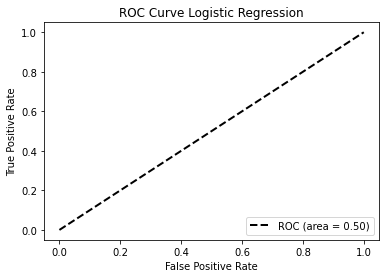

In [14]:
lr = LogisticRegression(max_iter = 10000, random_state = 11)
lr.fit(x_train, y_train.values.ravel())
pred_1 = lr.predict(x_test)
score_1 = accuracy_score(y_test.values.ravel(),pred_1)
auc_logit = metrics.roc_auc_score(y_test, pred_1)
print(score_1)
print("AUC Logistic Regression:", auc_logit)
fpr, tpr,thersholds=roc_curve(y_test, pred_1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve Logistic Regression')
plt.legend(loc="lower right")
plt.show()

AUC=0.5 means the classifier is not able to distinguish between Positive and Negative class points. Here the classifier is predicting  constant class(0) for all the data points.

## KNN (k-nearest neighbor)

0.9192708333333334
AUC KNN: 0.5286850021486893


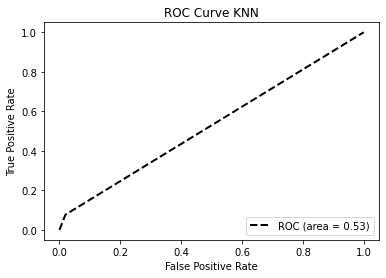

In [15]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train.values.ravel())
pred_2 = knn.predict(x_test)
score_2 = accuracy_score(y_test.values.ravel(), pred_2)
print(score_2)
auc_knn = metrics.roc_auc_score(y_test, pred_2)
print("AUC KNN:", auc_knn)
fpr, tpr,thersholds=roc_curve(y_test, pred_2)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve KNN')
plt.legend(loc="lower right")
plt.show()

The result is also not ideal.

## Decision Tree

0.8723958333333334
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       358
           1       0.23      0.38      0.29        26

    accuracy                           0.87       384
   macro avg       0.59      0.65      0.61       384
weighted avg       0.90      0.87      0.89       384

AUC Decision Tree: 0.6462183068328319


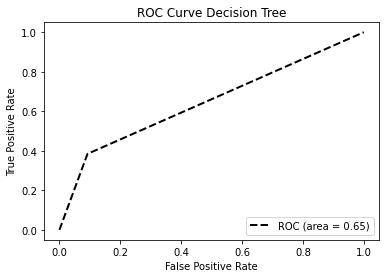

In [16]:
dt = DecisionTreeClassifier(random_state = 123)
dt.fit(x_train, y_train.values.ravel())
pred_3 = dt.predict(x_test)
score_3 = accuracy_score(y_test.values.ravel(), pred_3)
print(score_3)
print(classification_report(y_test, pred_3))
auc_dt = metrics.roc_auc_score(y_test, pred_3)
print("AUC Decision Tree:", auc_dt)
fpr, tpr,thersholds=roc_curve(y_test, pred_3)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve Decision Tree')
plt.legend(loc="lower right")
plt.show()

## Bagging

0.7552083333333334
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       358
           1       0.14      0.50      0.22        26

    accuracy                           0.76       384
   macro avg       0.55      0.64      0.54       384
weighted avg       0.90      0.76      0.81       384

AUC bag : 0.6368715083798884


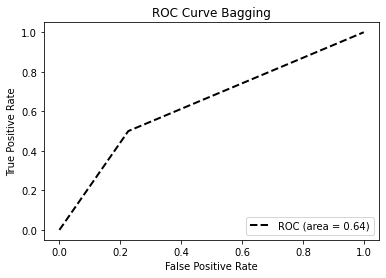

In [17]:
bag = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(),
                                 sampling_strategy = 'auto',
                                 replacement = False,
                                 random_state = 123)
bag.fit(x_train,y_train.values.ravel())
pred_4 = bag.predict(x_test)
score_4 = accuracy_score(y_test.values.ravel(), pred_4)
print(score_4)
print(classification_report(y_test, pred_4))
auc_bag = metrics.roc_auc_score(y_test, pred_4)
print("AUC bag :", auc_bag)
fpr, tpr, thersholds = roc_curve(y_test, pred_4)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve Bagging')
plt.legend(loc="lower right")
plt.show()

## Random Forest




0.9348958333333334
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       358
           1       0.60      0.12      0.19        26

    accuracy                           0.93       384
   macro avg       0.77      0.55      0.58       384
weighted avg       0.92      0.93      0.91       384

AUC Random Forest Classifier: 0.5548990116029222


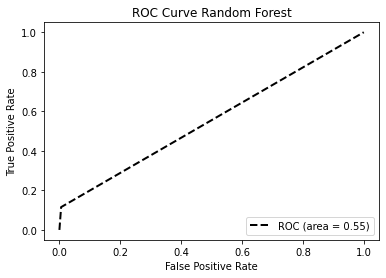

In [18]:
rfc = RandomForestClassifier(random_state = 123)
rfc.fit(x_train,y_train.values.ravel())
pred_5 = rfc.predict(x_test)
score_5 = accuracy_score(y_test.values.ravel(), pred_5)
print(score_5)
print(classification_report(y_test, pred_5))
auc_rfc = metrics.roc_auc_score(y_test, pred_5)
print("AUC Random Forest Classifier:", auc_rfc)
fpr, tpr, thersholds = roc_curve(y_test, pred_5)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve Random Forest')
plt.legend(loc="lower right")
plt.show()

## Gradient Boosting 

0.9348958333333334
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       358
           1       0.56      0.19      0.29        26

    accuracy                           0.93       384
   macro avg       0.75      0.59      0.63       384
weighted avg       0.92      0.93      0.92       384

AUC Gradient Boosting Classifier: 0.5905672539750751


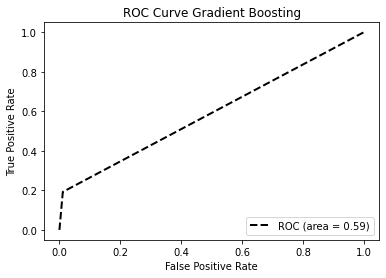

In [19]:
gbc = GradientBoostingClassifier(random_state = 123)
gbc.fit(x_train, y_train.values.ravel()) 
pred_6 = gbc.predict(x_test)
score_6=accuracy_score(y_test, pred_6)
print(score_6)
print(classification_report(y_test, pred_6))
auc_gbc = metrics.roc_auc_score(y_test, pred_6)
print("AUC Gradient Boosting Classifier:", auc_gbc)
fpr, tpr, thersholds = roc_curve(y_test, pred_6)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

<BarContainer object of 6 artists>

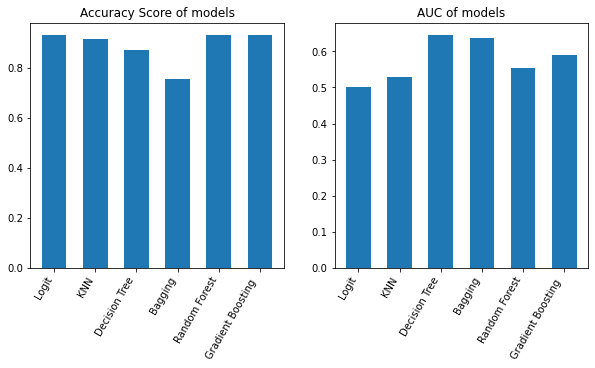

In [20]:
models=['Logit','KNN','Decision Tree','Bagging','Random Forest','Gradient Boosting ']
accuracy_score=[score_1,score_2,score_3,score_4,score_5,score_6]
AUC=[auc_logit,auc_knn,auc_dt,auc_bag,auc_rfc,auc_gbc]
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Accuracy Score of models')
fig.autofmt_xdate(rotation = 60)
plt.bar(models,accuracy_score,width=0.6)
plt.subplot(1,2,2)
fig.autofmt_xdate(rotation = 60)
plt.title('AUC of models')
plt.bar(models,AUC,width=0.6)

Among all the models, Decision Tree model the one works best in terms of accuracy and AUC

In [34]:
def predict_heatwave(Country,Year,January,February,March,April,May):
    dt_phw={'Country':Country,'Year':Year,'January':January,'February':February,'March':March,'April':April,'May':May}
    df_phw=pd.DataFrame(dt_phw)
    df_phw

array([[ 0.        ,  0.        ,  0.        , ..., -0.47711946,
        -0.70784431, -1.10161999],
       [ 0.        ,  0.        ,  0.        , ..., -0.13416106,
        -0.30971896, -0.44849635],
       [ 0.        ,  0.        ,  0.        , ..., -0.19747645,
         0.28098331,  0.27063446],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.57989592,
         0.3182348 ,  0.48950036],
       [ 0.        ,  0.        ,  0.        , ...,  0.72939061,
         0.41668518,  0.01405018],
       [ 0.        ,  0.        ,  0.        , ...,  0.05314699,
        -0.35462032, -0.26784513]])

In [ ]:
dt.predict()

In [36]:
predict_heatwave(1,2,3,4,5,6,7)

ValueError: If using all scalar values, you must pass an index

In [23]:
gg.

Country     Albania
Year           2004
January         6.7
February        8.5
March          11.7
April          15.8
May            17.6
Name: 0, dtype: object

In [ ]:
col_transform.fit_transform(gg).A

In [33]:
qwer=np.array([(1),(2),(3),(4),(5),(6),(7)])
df_qwer=pd.DataFrame(qwer)
df_qwer

,0
0,1
1,2
2,3
3,4
4,5
5,6
6,7


In [32]:
print(qwer)

[1 2 3 4 5 6 7]
